Файл з даними збережено: data/series_example.csv


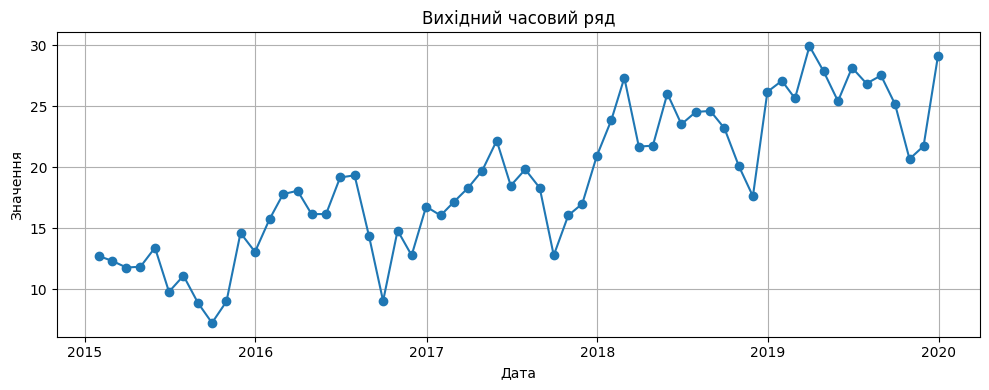


=== Критерій висхідних і низхідних серій (Runs Test) ===
Спостережені серії (runs): 34
Зростань: 34, Спадів: 25
Очікувані серії: 29.81
Z-статистика: 1.126
p-значення: 0.2601
Висновок: немає підстав відкидати випадковість, тенденція незначуща.


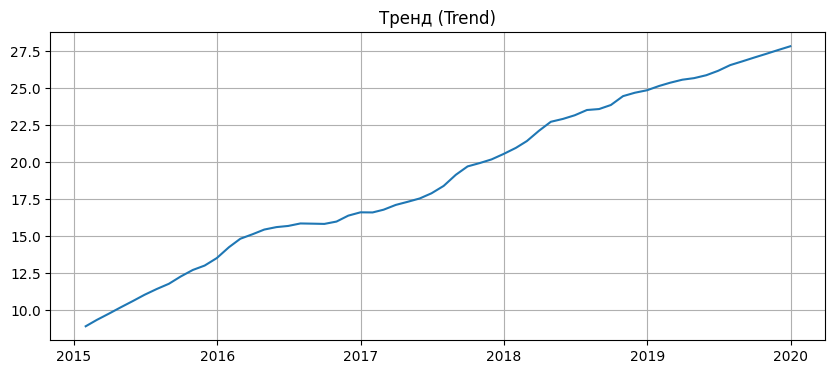

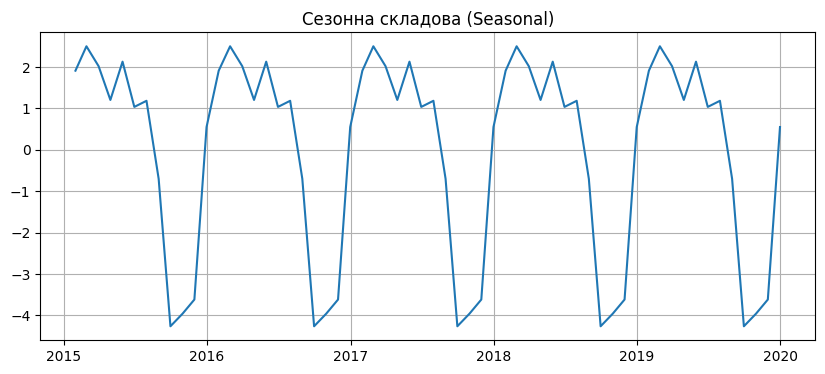

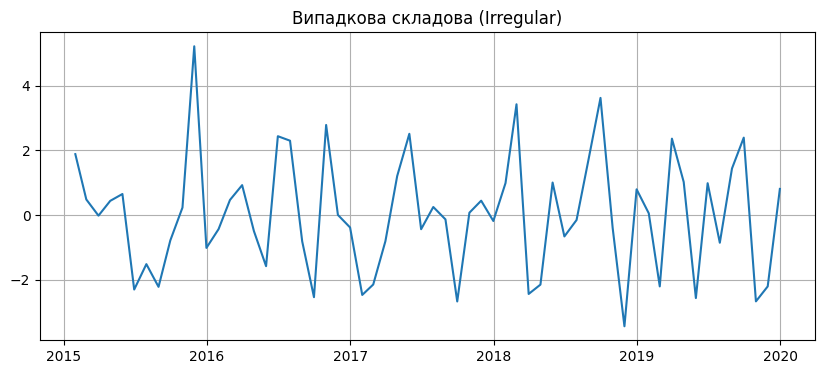

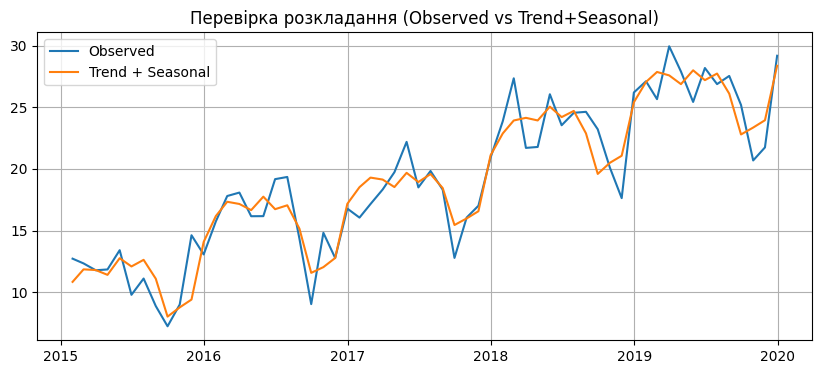

<Figure size 800x400 with 0 Axes>

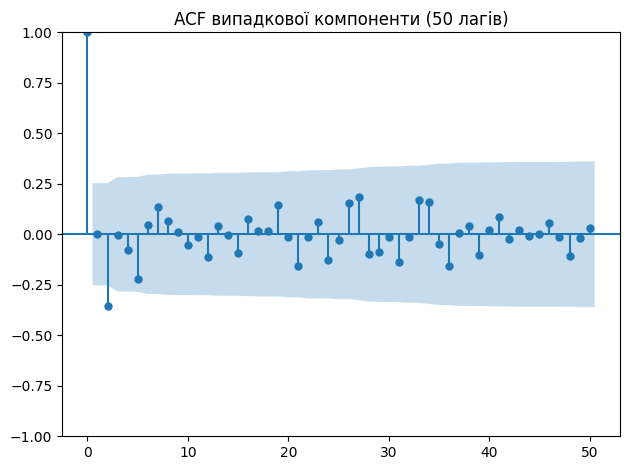


=== Перевірка коректності розкладення ===
Кількість лагів з автокореляцією > ±1.96/sqrt(N): 1 (lags: [2])
Висновок: у випадковій складовій залишилась автокореляція → можливе покращення моделі.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import os


start = "2015-01-01"
periods = 60
freq = "ME"
seasonal_period = 12


def generate_data(start, periods, freq, seasonal_period, trend_slope=0.3, noise_sd=2.0):
    idx = pd.date_range(start=start, periods=periods, freq=freq)
    t = np.arange(len(idx))
    trend = 10 + trend_slope * t
    seasonal = 3.5 * np.sin(2 * np.pi * t / seasonal_period) + 1.5 * np.cos(2 * np.pi * t / seasonal_period * 2)
    noise = np.random.normal(scale=noise_sd, size=len(idx))
    series = trend + seasonal + noise
    df = pd.DataFrame({"Date": idx, "Value": series})
    df.set_index("Date", inplace=True)
    return df


df = generate_data(start, periods, freq, seasonal_period)


os.makedirs("data", exist_ok=True)
out_csv = "data/series_example.csv"
df.to_csv(out_csv)
print(f"Файл з даними збережено: {out_csv}")


plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Value"], marker='o')
plt.title("Вихідний часовий ряд")
plt.xlabel("Дата")
plt.ylabel("Значення")
plt.grid(True)
plt.tight_layout()
plt.show()


diffs = np.diff(df["Value"].values)
signs = np.sign(diffs)
signs_nz = signs[signs != 0]
symbols = np.where(signs_nz > 0, 1, -1)


runs = 1 + np.sum(symbols[:-1] != symbols[1:])
n1 = np.sum(symbols == 1)
n2 = np.sum(symbols == -1)
n = n1 + n2


if n > 1:
    expected_runs = 1 + (2 * n1 * n2) / n
    var_runs = (2 * n1 * n2 * (2 * n1 * n2 - n)) / (n**2 * (n - 1))
    z = (runs - expected_runs) / np.sqrt(var_runs)
    p_val = 2 * (1 - stats.norm.cdf(abs(z)))
else:
    expected_runs = var_runs = z = p_val = np.nan


print("\n=== Критерій висхідних і низхідних серій (Runs Test) ===")
print(f"Спостережені серії (runs): {runs}")
print(f"Зростань: {n1}, Спадів: {n2}")
print(f"Очікувані серії: {expected_runs:.2f}")
print(f"Z-статистика: {z:.3f}")
print(f"p-значення: {p_val:.4f}")
if p_val < 0.05:
    print("Висновок: ряд не випадковий, є тенденція (тренд).")
else:
    print("Висновок: немає підстав відкидати випадковість, тенденція незначуща.")


result = seasonal_decompose(df["Value"], model="additive", period=seasonal_period, extrapolate_trend='freq')


plt.figure(figsize=(10, 4))
plt.plot(result.trend)
plt.title("Тренд (Trend)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(result.seasonal)
plt.title("Сезонна складова (Seasonal)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(result.resid)
plt.title("Випадкова складова (Irregular)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(result.observed, label="Observed")
plt.plot(result.trend + result.seasonal, label="Trend + Seasonal")
plt.legend()
plt.title("Перевірка розкладання (Observed vs Trend+Seasonal)")
plt.grid(True)
plt.show()


resid = result.resid.dropna()
plt.figure(figsize=(8, 4))
plot_acf(resid, lags=50, alpha=0.05)
plt.title("ACF випадкової компоненти (50 лагів)")
plt.tight_layout()
plt.show()


acf_vals = acf(resid, nlags=50, fft=True, missing='drop')
conf_limit = 1.96 / np.sqrt(len(resid))
significant_lags = np.where(np.abs(acf_vals) > conf_limit)[0]
significant_lags = significant_lags[significant_lags != 0]


print("\n=== Перевірка коректності розкладення ===")
print(f"Кількість лагів з автокореляцією > ±1.96/sqrt(N): {len(significant_lags)} (lags: {significant_lags.tolist()})")
if len(significant_lags) == 0:
    print("Висновок: випадкова складова не має автокореляції → розкладання коректне.")
else:
    print("Висновок: у випадковій складовій залишилась автокореляція → можливе покращення моделі.")


components_df = pd.DataFrame({
    "Observed": result.observed,
    "Trend": result.trend,
    "Seasonal": result.seasonal,
    "Residual": result.resid
})


components_csv = "data/series_components.csv"
components_df.to_csv(components_csv)